In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy.fft as fft


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from factor_repository.repositories import FactorRepositoryAG

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体，或者使用你系统上可用的其他字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


In [ ]:
table = pd.read_parquet(r'source\ag')
table['trading_date'] = pd.to_datetime(table['trading_date']) 

# 设置开始和结束时间
start_time = pd.to_datetime('2024-07-01')
end_time = pd.to_datetime('2024-07-01')

table = table[(table['trading_date'] >= start_time) & (table['trading_date'] <= end_time)]

# 当 AskPrice1 为 0 时，用 BidPrice1 替换
table['AskPrice1'] = table['AskPrice1'].where(table['AskPrice1'] != 0, table['BidPrice1'])

# 当 AskPrice1 为 0 时，用 AskPrice1 替换
table['BidPrice1'] = table['BidPrice1'].where(table['BidPrice1'] != 0, table['AskPrice1'])

In [3]:
#利用AskPrice1和BidPrice1计算价格的平均值，进而计算分钟频的收益率
def mid_price(df):
    mid = (df['AskPrice1'] + df['BidPrice1'])/2
    mid = mid.astype(float)
    return mid

In [4]:
def weighted_price(df):
    weighted = (df['AskPrice1']*df['BidVolume1'] + df['BidPrice1']*df['AskVolume1'])/(df['BidVolume1'] + df['AskVolume1'])
    weighted = weighted.astype(float)
    return weighted

In [5]:
table['current_volume'] = table['Volume'].diff()
table['Position Increase'] = table['OpenInterest'].diff()
table['current_turnover'] = table['Turnover'].diff()
table['current_avg_price'] = table['current_turnover']/(table['current_volume']*15)
table['mid_price'] = mid_price(table)
table['weighted_price'] = weighted_price(table)
# 计算买方委托量之和和卖方委托量之和，以及总委托量
table['BidVolume'] = table[['BidVolume1','BidVolume2','BidVolume3','BidVolume4','BidVolume5']].sum(axis=1)
table['AskVolume'] = table[['AskVolume1','AskVolume2','AskVolume3','AskVolume4','AskVolume5']].sum(axis=1)
table['Order_Volume'] = table['BidVolume'] + table['AskVolume']

In [6]:
#处理缺失值
# table['前一期Low Price比例'].replace([np.inf, -np.inf], np.nan, inplace=True)
# table['前一期High Price比例'].replace([np.inf, -np.inf], np.nan, inplace=True)
table['current_volume'].fillna(0,inplace=True)
table['Position Increase'].fillna(0,inplace=True)
table['current_turnover'].fillna(0,inplace=True)
table['current_avg_price'].replace([np.inf, -np.inf], np.nan, inplace=True)
table['current_avg_price'].fillna(method='ffill',inplace=True)
# table['前一期Low Price比例'].fillna(0,inplace=True)
# table['前一期High Price比例'].fillna(0,inplace=True)
# table['return'].fillna(0,inplace=True)

In [7]:
# table['current_volume_diff'] = table['current_volume'].diff()
# table['current_volume_diff'].fillna(0,inplace=True)
# table['fft_current_volume'] = fft.fft(table['current_volume'])
# data = table[120:180]['fft_current_volume']
# data.reset_index(drop=True)

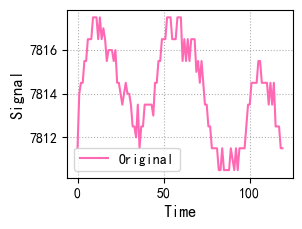

In [8]:
# table['mid_price_diff'] = table['mid_price'].diff()
# table['mid_price_diff'].fillna(0,inplace=True)

data = np.fft.fft(table[120:240]['mid_price']-table[120:240]['mid_price'].mean())

plt.subplot(223)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Signal', fontsize=12)
plt.tick_params(labelsize=10)
plt.grid(linestyle=':')
plt.plot(np.arange(0,120),table[120:240]['mid_price'], c='hotpink', label='Original')
plt.legend()

In [9]:
# plt.subplot(223)
# plt.xlabel('Time', fontsize=12)
# plt.ylabel('Signal', fontsize=12)
# plt.tick_params(labelsize=10)
# plt.grid(linestyle=':')
# plt.plot(np.arange(0,120),data, c='hotpink', label='Filter')
# plt.legend()

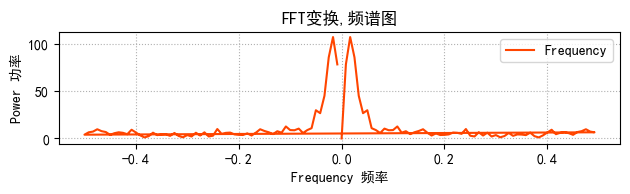

In [10]:
freqs = np.fft.fftfreq(len(data))
pows = np.abs(data)
# freqs = np.fft.fftfreq(len(data))
# pows = np.abs(data)**2

plt.subplot(313)
plt.title('FFT变换,频谱图')
plt.xlabel('Frequency 频率')
plt.ylabel('Power 功率')
plt.tick_params(labelsize=10)
plt.grid(linestyle=':')
plt.plot(freqs, pows, c='orangered', label='Frequency')
plt.legend()
plt.tight_layout()
plt.show()

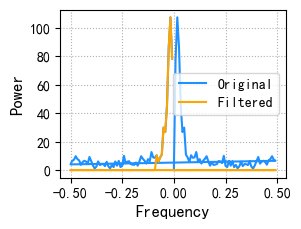

In [11]:
fund_freq = freqs[pows.argmax()]


# 寻找需要抹掉的噪声频率的索引
noised_indices = np.where(np.argsort(pows)[:-10])

# 复制一个数组以避免修改原始数据
filter_complex_array = data.copy()

# 将噪声频率的复数部分置为零
filter_complex_array[noised_indices] = 0

# 计算滤波后的功率
filter_pows = np.abs(filter_complex_array)




# def filter_top_3_frequencies(data):
#     # 对数据进行 FFT
#     fft_data = np.fft.fft(data)
#     freqs = np.fft.fftfreq(len(data))
#     pows = np.abs(fft_data)**2  # 计算功率谱
    
#     # 找到功率谱中前三大的频率的索引
#     sorted_indices = np.argsort(pows)[::-1]  # 按功率从大到小排序
#     top_3_indices = sorted_indices[:3]  # 取前三大频率的索引
    
#     # 创建一个新的数组，只保留前三大的频率，其他频率置为零
#     filter_complex_array = np.zeros_like(fft_data)
#     filter_complex_array[top_3_indices] = fft_data[top_3_indices]
    
#     # 进行逆傅里叶变换，恢复信号
#     filtered_signal = np.fft.ifft(filter_complex_array)
    
#     # 返回滤波后的信号的功率（即滤波后的幅度谱）
#     filter_pows = np.abs(filtered_signal)**2
    
#     return filtered_signal, filter_pows

# filtered_signal, filter_pows = filter_top_3_frequencies(data)



# 绘图
plt.subplot(224)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.tick_params(labelsize=10)
plt.grid(linestyle=':')
plt.plot(freqs, pows, c='dodgerblue', label='Original')
plt.plot(freqs, filter_pows, c='orange', label='Filtered')
plt.legend()
plt.show()


# # 绘图
# plt.subplot(224)
# plt.xlabel('Frequency', fontsize=12)
# plt.ylabel('Power', fontsize=12)
# plt.tick_params(labelsize=10)
# plt.grid(linestyle=':')
# plt.plot(freqs, pows, c='dodgerblue', label='Original')
# plt.plot(freqs, filter_pows, c='orange', label='Filtered')
# plt.legend()
# plt.show()

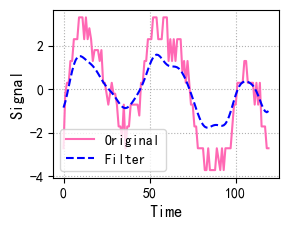

In [12]:
# 执行逆 FFT 以重建信号

filtered_signal = np.fft.ifft(filter_complex_array)
# table['fft_current_volume'] = fft.fft(table['current_volume'])
# table['ifft_current_volume'] = fft.ifft(table['fft_current_volume'])
plt.subplot(223)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Signal', fontsize=12)
plt.tick_params(labelsize=10)
plt.grid(linestyle=':')
plt.plot(np.arange(0,120),table[120:240]['mid_price']-table[120:240]['mid_price'].mean(), c='hotpink', label='Original')
plt.plot(np.arange(0,120),filtered_signal, c='Blue', label='Filter',linestyle='--')
plt.legend()

In [13]:
# freq = np.fft.fftfreq(len(data))

# # 提取正频率部分
# mask = freq >= 0
# freq_pos = freq[mask]
# magnitude = np.abs(data[mask])

# # 绘图
# plt.plot(freq_pos, magnitude)
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Amplitude")
# plt.show()

In [14]:
# df = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])
# fft_df = np.fft.fft(df)
# df1 = np.fft.ifft(fft_df)
# plt.subplot(223)
# plt.xlabel('Time', fontsize=12)
# plt.ylabel('Signal', fontsize=12)
# plt.tick_params(labelsize=10)
# plt.grid(linestyle=':')
# plt.plot(np.arange(0,10),df, c='hotpink', label='Original')
# plt.plot(np.arange(0,10),df1, c='Blue', label='Filter',linestyle='--')
# plt.legend()

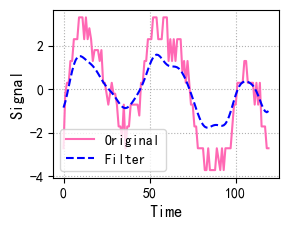

In [15]:
data = np.fft.fft(table[120:240]['mid_price']-table[120:240]['mid_price'].mean())
freqs = np.fft.fftfreq(len(data))
pows = np.abs(data)

# 寻找需要抹掉的噪声频率的索引
noised_indices = np.where(np.argsort(pows)[:-10])

# 复制一个数组以避免修改原始数据
filter_complex_array = data.copy()

# 将噪声频率的复数部分置为零
filter_complex_array[noised_indices] = 0

# 计算滤波后的功率
filter_pows = np.abs(filter_complex_array)

filtered_signal = np.fft.ifft(filter_complex_array)

plt.subplot(223)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Signal', fontsize=12)
plt.tick_params(labelsize=10)
plt.grid(linestyle=':')
plt.plot(np.arange(0,120),table[120:240]['mid_price']-table[120:240]['mid_price'].mean(), c='hotpink', label='Original')
plt.plot(np.arange(0,120),filtered_signal, c='Blue', label='Filter',linestyle='--')
plt.legend()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

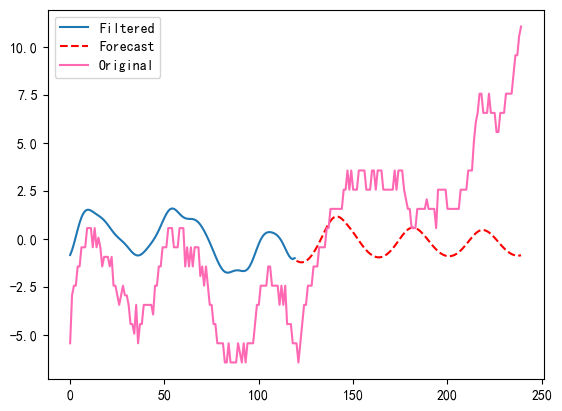

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np


time_series = filtered_signal.real  # 取实部
forecast_steps = 120

# 准备训练数据
data = time_series.reshape(-1, 1)
look_back = 10  # 用过去10个点预测下一个点

# 创建输入输出序列
X, y = [], []
for i in range(len(data) - look_back):
    X.append(data[i:i+look_back, 0])
    y.append(data[i+look_back, 0])
X = np.array(X)
y = np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)  # 调整为LSTM输入格式

# 构建并训练LSTM模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, batch_size=32, verbose=0)

# 生成预测
forecast = []
current_seq = X[-1]  # 最后已知序列
for _ in range(forecast_steps):
    next_pred = model.predict(current_seq.reshape(1, look_back, 1))[0,0]
    forecast.append(next_pred)
    current_seq = np.append(current_seq[1:], next_pred)

# 可视化
plt.plot(np.arange(120), time_series, label='Filtered')
plt.plot(np.arange(120, 120 + forecast_steps), forecast, 'r--', label='Forecast')
plt.plot(np.arange(0,240),table[120:360]['mid_price']-table[120:360]['mid_price'].mean(), c='hotpink', label='Original')
plt.legend()
plt.show()

[-1.1616565,
 -1.2099862,
 -1.2243444,
 -1.2028763,
 -1.1507647,
 -1.0841503,
 -1.0069412,
 -0.92305094,
 -0.83069223,
 -0.7316497,
 -0.62668854,
 -0.51729,
 -0.4054246,
 -0.2938601,
 -0.18575284,
 -0.08321887,
 0.011417694,
 0.09575773,
 0.16843629,
 0.22798607,
 0.27376366,
 0.30501008,
 0.32084057,
 0.321353,
 0.30662388,
 0.27713892,
 0.23358685,
 0.17697746,
 0.10868069,
 0.030427076,
 -0.055693917,
 -0.14722323,
 -0.24136207,
 -0.33499426,
 -0.4248005,
 -0.50742954,
 -0.5796713,
 -0.6386793,
 -0.68218184,
 -0.7086504,
 -0.71765447,
 -0.70997024,
 -0.6861971,
 -0.6483636,
 -0.5999533,
 -0.5425927,
 -0.47874808,
 -0.41049454,
 -0.34001595,
 -0.26904848,
 -0.19914281,
 -0.13217872,
 -0.069770455,
 -0.013172025,
 0.036255702,
 0.07762264,
 0.1098327,
 0.13230017,
 0.14471254,
 0.14693084,
 0.1389212,
 0.121072136,
 0.09391486,
 0.0582072,
 0.014945779,
 -0.034636013,
 -0.08908201,
 -0.14674062,
 -0.20579705,
 -0.26432177,
 -0.32033625,
 -0.37189752,
 -0.41718724,
 -0.45460963,
 -0.48